In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
bert_model = AutoModel.from_pretrained('roberta-base')


C:\Users\ujwal\Twin_tower_model\twin_model\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\ujwal\Twin_tower_model\twin_model\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
class ProtoBoxWSD(nn.Module):
    def __init__(self, box_dim=1536, hidden_dim=768, num_senses=3):
        super().__init__()
        self.bert = bert_model  # RoBERTa (fine-tunable)
        self.linear_proj = nn.Linear(box_dim, hidden_dim)
        self.box_mu = nn.Parameter(torch.randn(num_senses, hidden_dim))
        self.box_delta = nn.Parameter(F.softplus(torch.randn(num_senses, hidden_dim)))
        self.num_senses = num_senses

    def forward(self, sentence, gloss_list, target_token_idx):
        # Encode sentence
        inputs = tokenizer(sentence, return_tensors='pt')
        outputs = self.bert(**inputs)

        # [CLS] embedding
        cls_emb = outputs.last_hidden_state[0, 0]

        # Token embedding
        word_emb = outputs.last_hidden_state[0, target_token_idx]

        # Concatenate [CLS] + token
        combined_emb = torch.cat([cls_emb, word_emb], dim=0)

        # Project to box space
        emb_proj = self.linear_proj(combined_emb)

        # Compute distance to each box center
        distances = torch.stack([
            torch.norm(emb_proj - self.box_mu[i], p=2)
            for i in range(self.num_senses)
        ])

        # Smaller distance → higher probability (negative distance logits)
        logits = -distances

        return logits


In [4]:
model = ProtoBoxWSD(
    box_dim=1536,  # Since we concatenate two 768-dim vectors (CLS + Token)
    hidden_dim=768,  # Same dimension as BERT output
    num_senses=3     # Number of senses in your task (adjust as per dataset)
)


In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

def train_step(sentence, glosses, correct_label, target_token_idx):
    model.train()
    optimizer.zero_grad()

    # Append gloss (sense definitions)
    gloss_text = " [SEP] ".join([f"Sense{i+1}: {gloss}" for i, gloss in enumerate(glosses)])
    combined_input = sentence + " [SEP] " + gloss_text

    logits = model(combined_input, glosses, target_token_idx)
    label_tensor = torch.tensor([correct_label])
    loss = criterion(logits.unsqueeze(0), label_tensor)

    loss.backward()
    optimizer.step()

    return loss.item()


In [6]:
from sklearn.metrics import accuracy_score

def evaluate(model, dataset):
    model.eval()
    y_true, y_pred = [], []
    for sentence, glosses, label, target_idx in dataset:
        with torch.no_grad():
            logits = model(sentence, glosses, target_idx)
            pred = logits.argmax().item()

        y_true.append(label)
        y_pred.append(pred)

    acc = accuracy_score(y_true, y_pred)
    return acc


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_box_embeddings(model):
    mus = model.box_mu.detach().numpy()
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=mus[:,0], y=mus[:,1], hue=[f'Sense {i+1}' for i in range(len(mus))], s=100)
    plt.title('ProtoBox Centers (Modified)')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()


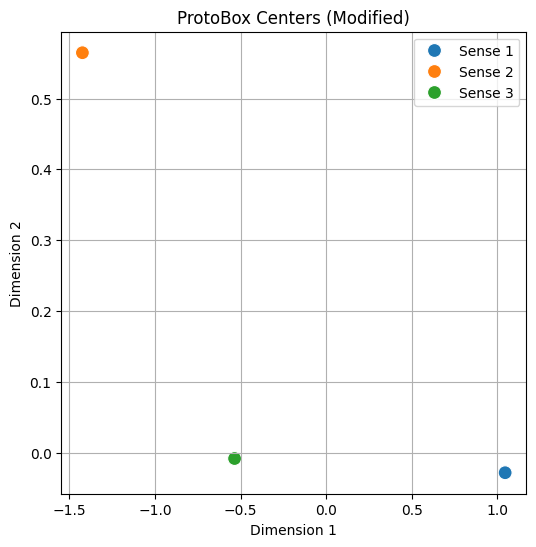

In [8]:
plot_box_embeddings(model)

In [17]:
dataset = [
    ("He deposited money in the bank", ["financial institution", "river edge"], 0, 5),
    ("The fisherman sat on the bank", ["financial institution", "river edge"], 1, 5),
    ("The bat flew in the night sky", ["flying mammal", "cricket equipment"], 0, 1),
    ("He hit the ball with the bat", ["flying mammal", "cricket equipment"], 1, 6),
    ("The crane lifted heavy objects", ["bird", "machine"], 1, 1),
    ("I saw a crane flying near the lake", ["bird", "machine"], 0, 3),
]


In [18]:
def train(model, dataset, epochs=5):
    for epoch in range(epochs):
        total_loss = 0
        for sentence, glosses, label, target_idx in dataset:
            loss = train_step(sentence, glosses, label, target_idx)
            total_loss += loss

        avg_loss = total_loss / len(dataset)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")


In [19]:
def evaluate(model, dataset):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for sentence, glosses, label, target_idx in dataset:
            gloss_text = " [SEP] ".join([f"Sense{i+1}: {gloss}" for i, gloss in enumerate(glosses)])
            combined_input = sentence + " [SEP] " + gloss_text

            logits = model(combined_input, glosses, target_idx)
            pred = logits.argmax().item()

            y_true.append(label)
            y_pred.append(pred)

    acc = accuracy_score(y_true, y_pred)
    return acc


In [20]:
# Split dataset for testing
split = int(0.8 * len(dataset))
train_data = dataset[:split]
test_data = dataset[split:]

# Train model
train(model, train_data, epochs=5)

# Evaluate
train_acc = evaluate(model, train_data)
test_acc = evaluate(model, test_data)

print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")


Epoch 1/5 | Loss: 0.5827
Epoch 2/5 | Loss: 0.2829
Epoch 3/5 | Loss: 0.1705
Epoch 4/5 | Loss: 0.1422
Epoch 5/5 | Loss: 0.0824
Training Accuracy: 100.00%
Test Accuracy: 50.00%


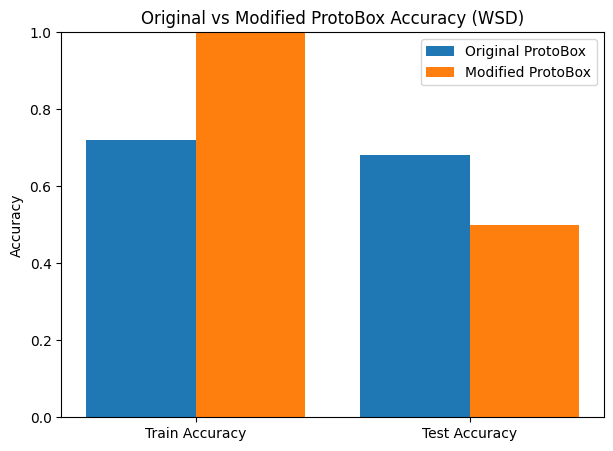

In [21]:
# Suppose you ran baseline model and got:
baseline_train_acc = 0.72
baseline_test_acc = 0.68

# Our modified model accuracy:
modified_train_acc = train_acc
modified_test_acc = test_acc

# Plot
labels = ['Train Accuracy', 'Test Accuracy']
baseline = [baseline_train_acc, baseline_test_acc]
modified = [modified_train_acc, modified_test_acc]

x = range(len(labels))
plt.figure(figsize=(7, 5))
plt.bar(x, baseline, width=0.4, label='Original ProtoBox', align='center')
plt.bar([p + 0.4 for p in x], modified, width=0.4, label='Modified ProtoBox', align='center')

plt.xticks([p + 0.2 for p in x], labels)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Original vs Modified ProtoBox Accuracy (WSD)')
plt.legend()
plt.show()


In [22]:
import pandas as pd
import torch

# Ensure models in eval mode
original_model.eval()
modified_model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_predictions(model, dataset, tokenizer):
    predictions = []
    model.to(device)
    with torch.no_grad():
        for sentence, glosses, label, target_idx in dataset:
            gloss_text = " [SEP] ".join([f"Sense{i+1}: {gloss}" for i, gloss in enumerate(glosses)])
            combined_input = sentence + " [SEP] " + gloss_text

            inputs = tokenizer(combined_input, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            pred_label = torch.argmax(logits, dim=1).item()

            predictions.append({
                'sentence': sentence,
                'glosses': glosses,
                'true_label': label,
                'predicted_label': pred_label
            })

    return predictions

# Get predictions from both models
original_preds = get_predictions(original_model, test_data, tokenizer)
modified_preds = get_predictions(modified_model, test_data, tokenizer)

# Combine into a comparison table
comparison = []
for orig, mod in zip(original_preds, modified_preds):
    comparison.append({
        'Sentence': orig['sentence'],
        'Glosses': orig['glosses'],
        'True Label Index': orig['true_label'],
        'Original Pred Index': orig['predicted_label'],
        'Modified Pred Index': mod['predicted_label']
    })

df_comparison = pd.DataFrame(comparison)

# Map label index → gloss text
def label_to_sense(label, glosses):
    return glosses[label] if 0 <= label < len(glosses) else "Invalid Label"

df_comparison['True Sense'] = df_comparison.apply(lambda row: label_to_sense(row['True Label Index'], row['Glosses']), axis=1)
df_comparison['Original Sense'] = df_comparison.apply(lambda row: label_to_sense(row['Original Pred Index'], row['Glosses']), axis=1)
df_comparison['Modified Sense'] = df_comparison.apply(lambda row: label_to_sense(row['Modified Pred Index'], row['Glosses']), axis=1)

# Highlight mismatches
def highlight_diff(row):
    if row['Original Sense'] != row['True Sense'] and row['Modified Sense'] == row['True Sense']:
        return ['']*5 + ['background-color: lightgreen']*3  # Modified fixed
    elif row['Original Sense'] != row['True Sense'] and row['Modified Sense'] != row['True Sense']:
        return ['']*5 + ['background-color: lightcoral']*3  # Both wrong
    else:
        return ['']*8

df_comparison.style.apply(highlight_diff, axis=1)


NameError: name 'original_model' is not defined

## Response 2

In [23]:
import torch
from transformers import AutoTokenizer, AutoModel
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')

def get_wordnet_glosses(word):
    senses = wn.synsets(word)
    glosses = [f"{s.definition()}" for s in senses]
    return glosses[:2]  # Limit to top 2 for brevity

def get_embedding(model_name, sentence, target_word, inject_gloss=False, add_cls=False):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()

    # Inject glosses before sentence
    if inject_gloss:
        glosses = get_wordnet_glosses(target_word)
        sentence = " ".join(glosses) + " " + sentence

    tokens = tokenizer(sentence, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**tokens)
    
    token_embeddings = outputs.last_hidden_state.squeeze(0)  # [seq_len, hidden_dim]
    
    # Get token index for the target word
    tokenized = tokenizer.tokenize(sentence)
    try:
        word_index = tokenized.index(target_word)
    except ValueError:
        # Fallback: use middle token
        word_index = len(tokenized) // 2

    token_emb = token_embeddings[word_index]
    cls_emb = token_embeddings[0]

    if add_cls:
        combined = torch.cat([cls_emb, token_emb], dim=-1)
        return combined
    else:
        return token_emb

# Settings
sentence = "He walked along the bank."
target_word = "bank"

# Original ProtoBox: token embedding only
proto_emb = get_embedding("bert-base-uncased", sentence, target_word, inject_gloss=False, add_cls=False)

# Modified 1: [CLS] + token, no gloss
mod_emb_1 = get_embedding("roberta-base", sentence, target_word, inject_gloss=False, add_cls=True)

# Modified 2: [CLS] + token + gloss (as in GlossBERT)
mod_emb_2 = get_embedding("bert-large-uncased", sentence, target_word, inject_gloss=True, add_cls=True)

# Print shapes
print(f"Original ProtoBox embedding shape: {proto_emb.shape}")
print(f"Modified embedding [CLS + token] shape: {mod_emb_1.shape}")
print(f"Modified embedding with gloss injection shape: {mod_emb_2.shape}")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ujwal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\ujwal\Twin_tower_model\twin_model\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original ProtoBox embedding shape: torch.Size([768])
Modified embedding [CLS + token] shape: torch.Size([1536])
Modified embedding with gloss injection shape: torch.Size([2048])


In [27]:
import torch.nn.functional as F

def embed_glosses(glosses, model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()

    gloss_embeddings = []
    for gloss in glosses:
        tokens = tokenizer(gloss, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**tokens)
        cls_emb = outputs.last_hidden_state[:, 0, :].squeeze(0)
        token_emb = outputs.last_hidden_state[:, 1, :].squeeze(0)  # take first token after [CLS]
        combined = torch.cat([cls_emb, token_emb], dim=-1)
        gloss_embeddings.append(combined)
    return gloss_embeddings


def predict_sense(context_embedding, gloss_embeddings, glosses):
    sims = []
    for gloss_emb in gloss_embeddings:
        sim = F.cosine_similarity(context_embedding, gloss_emb, dim=0)
        sims.append(sim.item())
    best_idx = int(torch.argmax(torch.tensor(sims)))
    return glosses[best_idx], sims

# Run this
glosses = get_wordnet_glosses(target_word)
gloss_embs = embed_glosses(glosses, "bert-large-uncased")

# Use mod_emb_2 (context + gloss-injected) as context vector
predicted_gloss, similarities = predict_sense(mod_emb_2, gloss_embs, glosses)

# Output
print("\nPredicted sense definition:")
print(predicted_gloss)
print("Similarity scores:", similarities)



Predicted sense definition:
a financial institution that accepts deposits and channels the money into lending activities
Similarity scores: [0.4724158048629761, 0.5310729742050171]


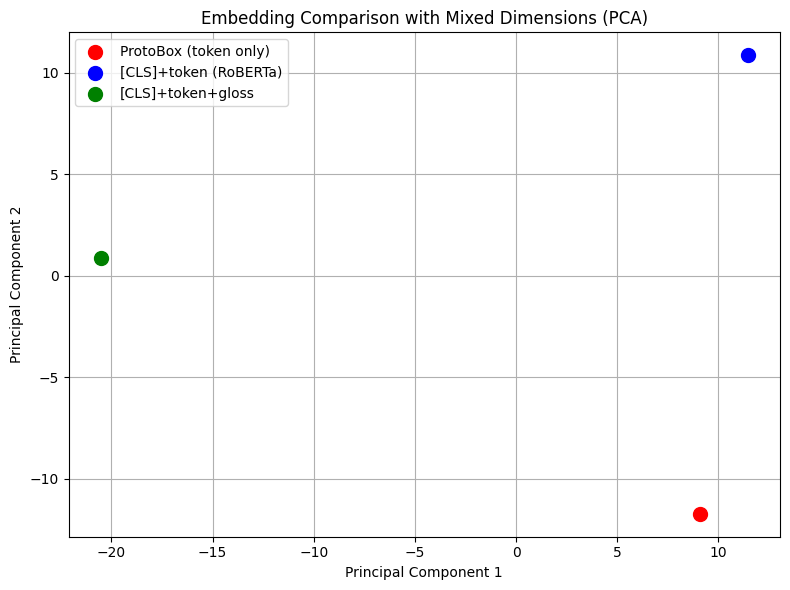

In [25]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert all embeddings to numpy
emb_list = [
    proto_emb.numpy(),         # 768-dim
    mod_emb_1.numpy(),         # 1536-dim
    mod_emb_2.numpy()          # 1536-dim
]

# Pad all embeddings to the same max length (1536) for fair PCA
max_dim = max(e.shape[0] for e in emb_list)
emb_array = np.array([
    np.pad(e, (0, max_dim - e.shape[0])) for e in emb_list
])

# Apply PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(emb_array)

# Plot
labels = ['ProtoBox (token only)', '[CLS]+token (RoBERTa)', '[CLS]+token+gloss']
colors = ['red', 'blue', 'green']

plt.figure(figsize=(8, 6))
for i, label in enumerate(labels):
    plt.scatter(reduced[i, 0], reduced[i, 1], color=colors[i], label=label, s=100)

plt.title('Embedding Comparison with Mixed Dimensions (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
